### Notebook to be used to perform manual focus testing using ACCS Images. In this case we're taking the focus at a few different wavelengths to look at the focus shift as a fxn of wavelength for an on-axis image (0th order).

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt

import SALPY_ATCamera
#import SALPY_ATSpectrograph
import SALPY_ATArchiver

In [2]:
#ATSpectrograph = salobj.Remote(SALPY_ATSpectrograph)
#
ATArchiver = salobj.Remote(SALPY_ATArchiver)

In [5]:
ATCamera = salobj.Remote(SALPY_ATCamera)

#### Setup the Camera

In [8]:
#  bring into enable state if required
if False:
    try:
        asyncio.get_event_loop().run_until_complete(ATCamera.cmd_enable.start())
    except AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")
#asyncio.get_event_loop().run_until_complete(ATCamera.cmd_start.start())

In [640]:
wavelength = 420
dist=86.85
#wavelength = 540
group_id='Focus'+str(wavelength)+str(dist)
ATCamera.cmd_takeImages.set(expTime=1, shutter=1, numImages=1, imageSequenceName=group_id)

True

In [641]:
try:
    asyncio.get_event_loop().run_until_complete(ATCamera.cmd_takeImages.start())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")

In [642]:
endReadout = asyncio.get_event_loop().run_until_complete(ATCamera.evt_endReadout.next(flush=False, timeout=30))
print(endReadout.imageName)

AT_O_20190531_000070


In [643]:
# Read in ima
#dir = '/mnt/dmcs/20180823'
dir = '/mnt/data/ats/mcm/20190531/'
#atcamera_fname='AT_O_20190403_000072'
atcamera_fname=endReadout.imageName

#dir = '/mnt/dmcs/2019-03-08/'
#atcamera_fname='AT_O_20190308_000125-ats-wfs_ccd'

full_file_name=dir+atcamera_fname+'.fits'
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
im=hdu_list[12].data # for camera data 12 is upper amp
#im=hdu_list[5].data # for camera data 5 lower amp

im0=im

bias_full_file_name='/mnt/dmcs/2019-04-05/AT_O_20190405_000053-ats-wfs_ccd.fits'
bias_hdu_list = fits.open(bias_full_file_name)
#hdu_list.info()
bias=bias_hdu_list[12].data # for camera data

im-=bias

# seems like the top part of the image is often bad, just setting to zero
im[0:10,:]=0


Opening /mnt/data/ats/mcm/20190531/AT_O_20190531_000070.fits


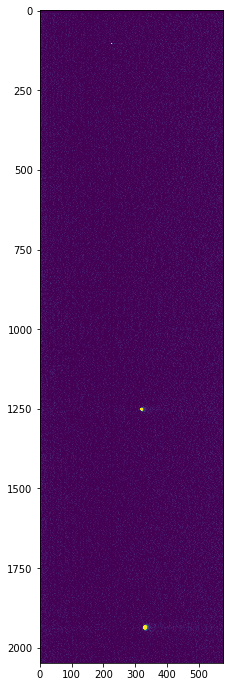

In [644]:
if True:
    plt.rcParams['figure.figsize'] = [14, 12]
    im_sub=im0 -np.median(im0)
    plt.imshow(im_sub, vmin=0, vmax=500)
    hdu_list.close()

In [645]:
# remove hot/bad pixels
from scipy.ndimage import median_filter
blurred = median_filter(im, size=3)
difference = im - blurred
threshold = 10*np.std(difference)
im_badpix_corr = np.empty_like(im)
im_badpix_corr[:] = im
#im_badpix_corr[difference>threshold] = 0

In [646]:
# Find star by convolution with gaussian, then grab the max
star_finder_img=gaussian_filter(im,[5,5],order=0, mode='constant',cval=0)

# Cut out the area with the 1st order image
half_side = 20
zero_ord_pos = [1898, 403]
ymin = zero_ord_pos[0]-half_side if zero_ord_pos[0]-half_side > 0 else 0
ymax = zero_ord_pos[0]+half_side if zero_ord_pos[0]+half_side < 2047 else 2047
xmin = zero_ord_pos[1]-half_side if zero_ord_pos[1]-half_side > 0 else 0
xmax = zero_ord_pos[1]+half_side if zero_ord_pos[1]+half_side < 512 else 512
if False:
    print('Cutting out area with zero order image')
    print('ymin,ymax,xmin,xmax = [{}, {}, {}, {}]'.format(ymin,ymax,xmin,xmax))
    star_finder_img[ymin:ymax,xmin:xmax] = -1e9 #np.nan

# If the wavelength is longer than 700nm, then there will be 2nd order contamination.
# This means that the "star" finder below will find the wrong peak if the 2nd order is brighter than the first.
if True and wavelength > 700:
    print('Removing 2nd order light from star finding image')
    #star_finder_img[800::,:]=-1e99

#print(np.max(star_finder_img))
value=None
ind=np.argmax(star_finder_img)
ind2d = np.unravel_index(ind,star_finder_img.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

centroid at y,x: 1936 328


In [647]:
# Create sub-image
#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(30)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < 2047 else 2047
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < 512 else 512
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(star_finder_img[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,star_finder_img[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

subimage being made from ymin,ymax,xmin,xmax:1906 1966 298 358
new centroid at y,x: 30 30


4864


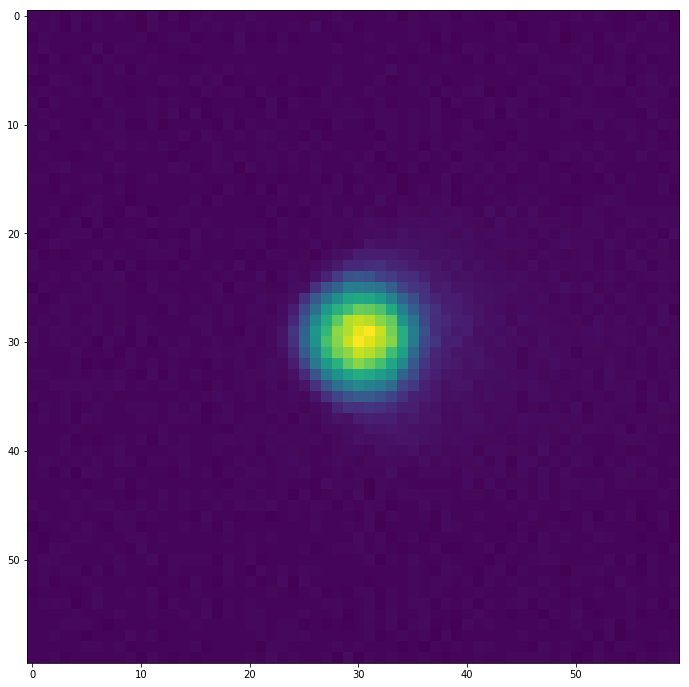

In [648]:
im_sub=im0[ymin:ymax,xmin:xmax]
#im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)
hdu_list.close()
print(np.nanmax(im_sub))

30
30


Text(0.5,1,'Residual')

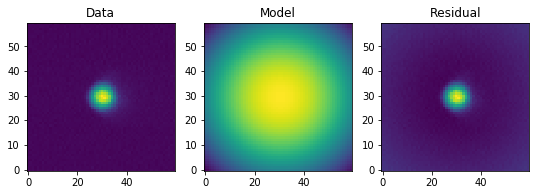

In [649]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [650]:
#print(atcamera_fname)
#print(repr(p))
print(['dist', 'filename', p.param_names[0:5],'wavelength'])
print('{}, {}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.2f}'.format(dist,
    atcamera_fname, p.amplitude.value, p.x_mean.value+xmin, p.y_mean.value+ymin,
    p.x_stddev.value, p.y_stddev.value, wavelength))

['dist', 'filename', ('amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev'), 'wavelength']
86.85, AT_O_20190531_000070, 1553.562, 328.467, 1935.579, 45.446, 44.058, 420.00


In [651]:
#### file, focus pos [in], amplitude, x_mean, y_mean, x_stddev, y_stddev, theta [fixed] 
# no filter, 90 l/mm disperser, stage at 64.998

AT_O_20190531_000007, 113678.979, 30.187, 29.801, 2.688, 2.405, 840.00
AT_O_20190531_000014, 133893.199, 29.801, 29.713, 2.740, 2.414, 840.00

# 467nm with LED - first order on top amp
87.00mm, AT_O_20190531_000024, 17643.624, 29.626, 29.754, 2.340, 2.664, 467.00
87.25, AT_O_20190531_000025, 10856.168, 29.449, 30.147, 3.462, 3.300, 467.00
86.85, AT_O_20190531_000026, 11715.894, 29.673, 29.732, 3.316, 3.167, 467.00
86.95, AT_O_20190531_000027, 17004.892, 29.957, 30.066, 2.471, 2.641, 467.00
87.04, AT_O_20190531_000028, 16138.326, 30.123, 29.701, 2.529, 2.668, 467.00
# changed to using real coords
86.92, AT_O_20190531_000029, 16141.895, 324.567, 1852.512, 2.611, 2.667, 467.00
# zero order, monochromator - looks good but didn't refocus to make sure it's the minimum
86.92, AT_O_20190531_000031, 223906.735, 343.086, 1849.338, 2.003, 2.005, 467.00
# now 600nm, zero order
86.92, AT_O_20190531_000032, 207960.888, 341.888, 1849.334, 2.141, 2.098, 600.00
87.25, AT_O_20190531_000034, 30913.020, 412.639, 1908.896, 5.076, 5.410, 600.00
86.7, AT_O_20190531_000036, 51648.831, 400.566, 1958.931, 2.402, 2.431, 600.00
86.84, AT_O_20190531_000037, 75508.349, 298.825, 1927.433, 2.083, 1.829, 600.00-- best
86.96, AT_O_20190531_000038, 53034.726, 377.386, 1955.421, 2.289, 2.200, 600.00
86.76, AT_O_20190531_000039, 68519.528, 284.136, 1985.388, 2.105, 2.043, 600.00
86.81, AT_O_20190531_000040, 68227.529, 289.105, 1916.142, 2.104, 1.847, 600.00
# clearly the answer is between 
86.81, AT_O_20190531_000041, 25749.790, 289.737, 1915.881, 2.957, 2.977, 750.00 - ugly fit
87.36, AT_O_20190531_000043, 13831.055, 360.261, 1906.859, 3.922, 3.669, 750.00 
86.77, AT_O_20190531_000044, 2582.928, 293.264, 1906.022, 22.322, 22.046, 750.00 - ugly fit
86.41, AT_O_20190531_000045, 2182.284, 347.110, 1961.475, 27.402, 26.801, 750.00 - miles out of focus
86.83, AT_O_20190531_000046, 23561.797, 245.852, 1980.204, 2.897, 2.778, 750.00
86.95, AT_O_20190531_000047, 40046.646, 325.428, 1921.446, 1.933, 2.170, 750.00
87.04, AT_O_20190531_000048, 39507.743, 354.630, 1953.147, 2.022, 2.012, 750.00
87.15, AT_O_20190531_000049, 23943.759, 405.452, 1942.195, 2.632, 2.587, 750.00
87.02, AT_O_20190531_000050, 40259.667, 371.886, 1899.658, 1.896, 1.982, 750.00 -- best
# now 840
87.02, AT_O_20190531_000051, 30181.765, 371.660, 1900.632, 2.878, 2.664, 840.00 - confirmed 0th order
87.17, AT_O_20190531_000052, 50750.334, 345.599, 1934.430, 2.277, 1.780, 840.00 - confirmed 0th - changed amps
87.39, AT_O_20190531_000053, 17984.397, 221.008, 1975.858, 3.738, 3.362, 840.00
87.17, AT_O_20190531_000054, 48190.002, 377.744, 1976.565, 2.247, 1.845, 840.00 - best 
87.27, AT_O_20190531_000055, 41064.956, 376.591, 1992.170, 2.394, 2.011, 840.00
87.11, AT_O_20190531_000056, 39158.730, 426.734, 1907.060, 2.487, 2.098, 840.00
#now 980
87.11, AT_O_20190531_000058, 21749.530, 429.316, 1906.240, 3.897, 3.706, 980.00
87.35, AT_O_20190531_000060, 9629.231, 308.776, 1924.182, 7.068, 6.968, 980.00 - ugly fit
87.56, AT_O_20190531_000063, 3304.814, 303.216, 1929.562, 18.663, 18.650, 980.00 - spot looks ok but fit is horrid
87.68, AT_O_20190531_000064, 2744.088, 380.749, 1892.950, 22.552, 21.715, 980.00 - looks worse
87.36, AT_O_20190531_000065, 3894.915, 292.075, 1952.332, 16.055, 15.894, 980.00 - hard to say
87.18, AT_O_20190531_000066, 13746.440, 360.553, 1935.272, 4.737, 4.261, 980.00 - good fit but clearly fat
87.01, AT_O_20190531_000067, 29477.827, 359.356, 1867.153, 2.919, 2.701, 980.00
86.92, AT_O_20190531_000068, 52632.771, 338.608, 1882.602, 2.162, 1.956, 980.00 - amazing
86.85, AT_O_20190531_000069, 51624.989, 325.525, 1935.673, 2.317, 2.060, 980.00



SyntaxError: invalid syntax (<ipython-input-651-b1bb60a50825>, line 8)

In [ ]:
# magnification of the system is ~3.2, so 15um pinhole becomes 48um, which is a width of ~5 pixels
# but it'll be resolved... 5 pixel wide top hat convolved with the diffraction limit (for a perfect system)
# diffraction limit is 3.1 pixels FWHM. 
#The zemax model shows that we're not going to (easily) resolve the pinhole, so it'll basically
# be a Gaussian. Moreover, we're definitely not using a perfect optical system so there's
# aberrations that will certainly reduce our resolution. I expect to measure a Gaussian profile.

In [239]:
632e-9*400/24. * 1e6

10.533333333333335

In [346]:
632/120

5.266666666666667

In [288]:
# Make an encircled energy plot
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])
#print(x_arr)
#print(tmp)
x_index_arr_2d=pix_index_1d_arr*ones_array_2d
x_arr_2d=x_index_arr_2d - p.x_mean.value
y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
# create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [289]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [290]:
r_arr_1d=np.reshape(r_arr_2d,(2*half_side)**2)
values = np.reshape(z,(2*half_side)**2)

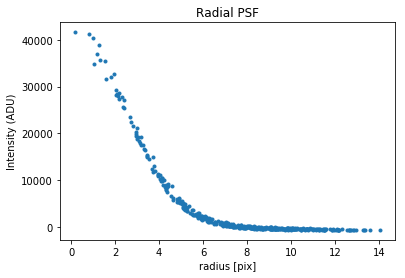

In [291]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(r_arr_1d, values,'.')
    plt.title('Radial PSF')
    plt.xlabel('radius [pix]')
    plt.show()
    plt.close()